<a href="https://colab.research.google.com/github/Ashis-Palai/Porto-Seguro-Safe-s-Driver-Prediction/blob/main/Porto_Seguros_Safe_Driver_prediction_Modelling_submitted_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import pickle
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import random
import decimal
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
train_data=pd.read_csv('/content/drive/MyDrive/train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/test.csv')
print('Shape of train data set is :',train_data.shape)
print('Shape of test data set is :',test_data.shape)

Shape of train data set is : (595212, 59)
Shape of test data set is : (892816, 58)


In [ ]:
train_data.head()
X=train_data.drop(['id','target'],axis=1)
Y=train_data['target']
print('Train Input Shape',X.shape)
print('Train Output Shape',Y.shape)

Train Input Shape (595212, 57)
Train Output Shape (595212,)


## **1.Important Features as Per Feature Engineering:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Calc Features are dropped as per domain knowledge and kaggle discussion
Top_Features_wrapper= ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_car_01_cat', 'ps_car_06_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_15']
Top_Features_ANOVA= ['ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_car_12', 'ps_car_13','ps_car_15']
Top_Features_MI= ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin','ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_12_bin','ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_car_01_cat','ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat','ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
Top_Features_Statistical=Top_Features_ANOVA+Top_Features_MI
# Final features common to both methods
Final_features=(list(set(set(Top_Features_wrapper) | set(Top_Features_Statistical))))
print('length of final list of features is :',len(Final_features))


length of final list of features is : 28


In [ ]:
X_Train_Final=X[Final_features]
print('Train Input Shape',X_Train_Final.shape)
print('Train Output Shape',Y.shape)


Train Input Shape (595212, 28)
Train Output Shape (595212,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_Train_Final,Y, test_size=0.2, random_state=42)
print('X_train Shape',X_train.shape)
print('y_train Shape',y_train.shape)
print('X_test Shape',X_test.shape)
print('y_test Shape',y_test.shape)



X_train Shape (476169, 28)
y_train Shape (476169,)
X_test Shape (119043, 28)
y_test Shape (119043,)


## **2.Evaluation Matrix Normalized Gini Coefficient:**

In [ ]:
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)
#__________________________ 
def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True
#__________________________ 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

## **3.Hyper Parameter Tuning on Possible numbers :**

In [ ]:
learning_rate=[0.06,0.07,0.08,0.09,0.1,0.11,0.15,0.17,0.19,0.20,0.099,0.098,0.13]
subsample=[0.4,0.5,0.61,0.63,0.66,0.70,0.71,0.73,0.75,0.77,0.79,0.8,0.82,0.85,0.86,0.87,0.89,0.9]
colsample_bytree=[0.4,0.5,0.61,0.63,0.66,0.70,0.71,0.73,0.75,0.77,0.79,0.8,0.82,0.85,0.86,0.87,0.89,0.9]
reg_alpha=[15,16,17,18,19,20,21,22,23,24,25]
reg_lambda=[0.99,0,95,0,97,1,0,0.01,0.02,0.03,0.04,0.05,1.1,1.3,1.5,1.6]
max_depth= [2,3, 4, 5,6,7,8,9,10,11,12,13]
num_leaves= [10,14,15,16,17,18,1940,42,44,46,47,49,50]
min_data_in_leaf=[30,35,40,45,50,55,65,75,85,95,105,115,125,135,145,150,165]

for j in range(30):
    results=[]
    for i in range(10):
        params = {'learning_rate': random.choice(learning_rate),
                      'subsample': random.choice(subsample),
               'colsample_bytree': random.choice(colsample_bytree),
                      'reg_alpha': random.choice(reg_alpha),
                     'reg_lambda': random.choice(reg_lambda),
                     'max_depth' : random.choice(max_depth),
                     'num_leaves': random.choice(num_leaves),        
               'min_data_in_leaf': random.choice(min_data_in_leaf), 
                       'boosting': 'gbdt',
                      'objective': 'binary',
             'is_training_metric': False,
                           'seed': 99,
                        'verbose': -1,
                        'n_jobs' : -1
                  }
        sss = StratifiedKFold(n_splits = 5, shuffle = True, random_state=i+j+15)
        for train_index, valid_index in sss.split(X_train,y_train):
            x_tr, x_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
            y_tr, y_valid = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[valid_index]
            lgb_train = lgb.Dataset(x_tr, label=y_tr)
            lgb_eval = lgb.Dataset(x_valid, label=y_valid)
            mdl = lgb.train(params,lgb_train,valid_sets=[lgb_eval,lgb_train],verbose_eval=25, feval=gini_lgb,early_stopping_rounds=50)
            results.append((mdl.best_score,mdl.params))
    pd.DataFrame(results).to_csv('result_'+str(j)+'.csv')

In [ ]:
import os
for i in os.listdir('/content/Untitled Folder'):
  score_=pd.read_csv('/content/Untitled Folder/'+i)
  print(max([(float((i[1].split(',')[-1])[:15]),i[2]) for i in score_.values ])[0])
  print(max([(float((i[1].split(',')[-1])[:15]),i[2]) for i in score_.values ])[1])

0.292527120494
{'learning_rate': 0.08, 'subsample': 0.61, 'colsample_bytree': 0.73, 'reg_alpha': 15, 'reg_lambda': 1.3, 'max_depth': 11, 'num_leaves': 17, 'min_data_in_leaf': 95, 'boosting': 'gbdt', 'objective': 'binary', 'is_training_metric': False, 'seed': 99, 'verbose': -1, 'n_jobs': -1, 'num_iterations': 100, 'early_stopping_round': 50}
0.293573556404
{'learning_rate': 0.099, 'subsample': 0.7, 'colsample_bytree': 0.63, 'reg_alpha': 25, 'reg_lambda': 95, 'max_depth': 11, 'num_leaves': 49, 'min_data_in_leaf': 135, 'boosting': 'gbdt', 'objective': 'binary', 'is_training_metric': False, 'seed': 99, 'verbose': -1, 'n_jobs': -1, 'num_iterations': 100, 'early_stopping_round': 50}
0.294765498199
{'learning_rate': 0.19, 'subsample': 0.63, 'colsample_bytree': 0.75, 'reg_alpha': 17, 'reg_lambda': 0.01, 'max_depth': 7, 'num_leaves': 16, 'min_data_in_leaf': 75, 'boosting': 'gbdt', 'objective': 'binary', 'is_training_metric': False, 'seed': 99, 'verbose': -1, 'n_jobs': -1, 'num_iterations': 100,

**3.1 OBSERVATIONS:**


*   Maximum validation Normalized gini score is **0.2951**
*   We will try to fine tune more based on above results



In [ ]:
for j in range(10):
    results=[]
    for i in range(10):
        params = {'learning_rate': 0.1,
                      'subsample': 0.6,
               'colsample_bytree': float(decimal.Decimal(random.randrange(70, 80))/100),
                      'reg_alpha': int(decimal.Decimal(random.randrange(12, 15))),
                     'reg_lambda': 0.0,
                     'max_depth' : int(decimal.Decimal(random.randrange(5, 9))),
                     'num_leaves': int(decimal.Decimal(random.randrange(15,20))),        
               'min_data_in_leaf': int(decimal.Decimal(random.randrange(85,100))), 
                       'boosting': 'gbdt',
                      'objective': 'binary',
             'is_training_metric': False,
                           'seed': 99,
                        'verbose': -1,
                        'n_jobs' : -1
                  }
        sss = StratifiedKFold(n_splits = 6, shuffle = True, random_state=i+j+15)
        for train_index, valid_index in sss.split(X_train,y_train):
            x_tr, x_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
            y_tr, y_valid = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[valid_index]
            lgb_train = lgb.Dataset(x_tr, label=y_tr)
            lgb_eval = lgb.Dataset(x_valid, label=y_valid)
            mdl = lgb.train(params,lgb_train,valid_sets=[lgb_eval,lgb_train],verbose_eval=25, feval=gini_lgb,early_stopping_rounds=50)
            results.append((mdl.best_score,mdl.params))
    pd.DataFrame(results).to_csv('result_3'+str(j)+'.csv')

Training until validation scores don't improve for 50 rounds
[25]	training's binary_logloss: 0.151144	training's gini: 0.31322	valid_0's binary_logloss: 0.152145	valid_0's gini: 0.27845
[50]	training's binary_logloss: 0.149656	training's gini: 0.344616	valid_0's binary_logloss: 0.151619	valid_0's gini: 0.28675
[75]	training's binary_logloss: 0.148561	training's gini: 0.371363	valid_0's binary_logloss: 0.151483	valid_0's gini: 0.289561
[100]	training's binary_logloss: 0.147609	training's gini: 0.394255	valid_0's binary_logloss: 0.151487	valid_0's gini: 0.28943
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.147609	training's gini: 0.394255	valid_0's binary_logloss: 0.151487	valid_0's gini: 0.28943
Training until validation scores don't improve for 50 rounds
[25]	training's binary_logloss: 0.151077	training's gini: 0.315061	valid_0's binary_logloss: 0.152452	valid_0's gini: 0.258776
[50]	training's binary_logloss: 0.149593	training's gini: 0.346173	vali

In [ ]:
import os
for i in os.listdir('/content/Final'):
  score_=pd.read_csv('/content/Final/'+i)
  print(max([(float((i[1].split(',')[-1])[:15]),i[2]) for i in score_.values ])[0])
  print(max([(float((i[1].split(',')[-1])[:15]),i[2]) for i in score_.values ])[1])


0.293378268213
{'learning_rate': 0.1, 'subsample': 0.78, 'colsample_bytree': 0.7, 'reg_alpha': 19, 'reg_lambda': 1.0, 'max_depth': 5, 'num_leaves': 58, 'min_data_in_leaf': 75, 'boosting': 'gbdt', 'objective': 'binary', 'is_training_metric': False, 'seed': 99, 'verbose': -1, 'n_jobs': -1, 'num_iterations': 100, 'early_stopping_round': 50}
0.315074363722
{'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.71, 'reg_alpha': 13, 'reg_lambda': 0.0, 'max_depth': 6, 'num_leaves': 16, 'min_data_in_leaf': 86, 'boosting': 'gbdt', 'objective': 'binary', 'is_training_metric': False, 'seed': 99, 'verbose': -1, 'n_jobs': -1, 'num_iterations': 100, 'early_stopping_round': 50}
0.280835265444
{'learning_rate': 0.5, 'subsample': 0.65, 'colsample_bytree': 0.8, 'reg_alpha': 24, 'reg_lambda': 0.8, 'max_depth': 18, 'num_leaves': 33, 'min_data_in_leaf': 117, 'boosting': 'gbdt', 'objective': 'binary', 'is_training_metric': False, 'seed': 99, 'verbose': -1, 'n_jobs': -1, 'num_iterations': 100, 'early

**3.2 OBSERVATIONS:**


*   Maximum validation Normalized gini score is **0.3200**
*   we will use the coresponding parameters as our final paramater for the Model

## **4.Training Final Model :**

In [ ]:
import os
import ast
for i in os.listdir('/content/Final'):
  score_=pd.read_csv('/content/Final/'+i)
  if max([(float((i[1].split(',')[-1])[:15]),i[2]) for i in score_.values ])[0]>=0.32:
    param=ast.literal_eval(str(max([(float((i[1].split(',')[-1])[:15]),i[2]) for i in score_.values ])[1]))
    print(' Highest Gini Score is {} with file name {}'.format(max([(float((i[1].split(',')[-1])[:15]),i[2]) for i in score_.values ])[0],i))
    print('final parameter is :',param)


 Highest Gini Score is 0.320066093431 with file name result_(48).csv
final parameter is : {'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.76, 'reg_alpha': 14, 'reg_lambda': 0.0, 'max_depth': 7, 'num_leaves': 16, 'min_data_in_leaf': 85, 'boosting': 'gbdt', 'objective': 'binary', 'is_training_metric': False, 'seed': 99, 'verbose': -1, 'n_jobs': -1, 'num_iterations': 100, 'early_stopping_round': 50}


In [ ]:
param={'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.76, 'reg_alpha': 14, 'reg_lambda': 0.0, 'max_depth': 7, 'num_leaves': 16, 'min_data_in_leaf': 85, 'boosting': 'gbdt', 'objective': 'binary', 'is_training_metric': False, 'seed': 99, 'verbose': -1, 'n_jobs': -1, 'num_iterations': 100, 'early_stopping_round': 50}


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

sss = StratifiedKFold(n_splits = 20, shuffle = True, random_state=15)
for train_index, valid_index in sss.split(X_train,y_train):
  x_tr, x_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
  y_tr, y_valid = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[valid_index]
  lgb_train = lgb.Dataset(x_tr, label=y_tr)
  lgb_eval = lgb.Dataset(x_valid, label=y_valid)
  mdl = lgb.train(param,lgb_train,valid_sets=[lgb_eval,lgb_train],verbose_eval=25, feval=gini_lgb,early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds.
[25]	training's binary_logloss: 0.151999	training's gini: 0.281414	valid_0's binary_logloss: 0.151897	valid_0's gini: 0.290582
[50]	training's binary_logloss: 0.151168	training's gini: 0.297332	valid_0's binary_logloss: 0.15124	valid_0's gini: 0.301077
[75]	training's binary_logloss: 0.150711	training's gini: 0.308606	valid_0's binary_logloss: 0.15098	valid_0's gini: 0.308578
[100]	training's binary_logloss: 0.15039	training's gini: 0.316312	valid_0's binary_logloss: 0.150846	valid_0's gini: 0.312507
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.15039	training's gini: 0.316312	valid_0's binary_logloss: 0.150846	valid_0's gini: 0.312507
Training until validation scores don't improve for 50 rounds.
[25]	training's binary_logloss: 0.151953	training's gini: 0.281382	valid_0's binary_logloss: 0.152659	valid_0's gini: 0.257192
[50]	training's binary_logloss: 0.151119	training's gini: 0.298444	v

In [ ]:
filename = '/content/final_model.sav'
pickle.dump(mdl, open(filename, 'wb'))


In [ ]:
Final_Model1= pickle.load(open('/content/final_model.sav', 'rb'))

 **4.1 Normalized Gini Score on Test Data using Final Model :**

In [ ]:
print('Normalised Gini Score on test data is :',gini_normalized(y_test, Final_Model1.predict(X_test)))

Normalised Gini Score on test data is : 0.28814136127164397


 **4.2 F1 Score Calculation :**

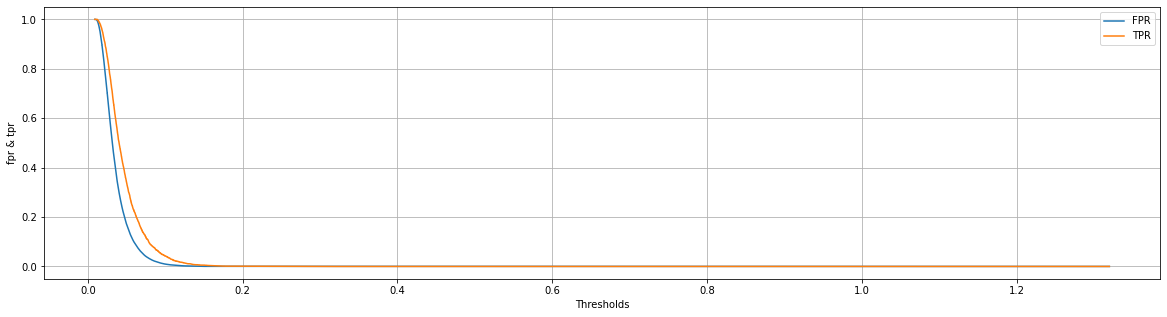

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, mdl.predict(X_test), pos_label=1)
f = plt.figure(figsize=(20,5))
plt.plot(thresholds,fpr,label='FPR')
plt.plot(thresholds,tpr,label='TPR')
plt.xlabel('Thresholds')
plt.ylabel('fpr & tpr')
plt.xlabel
plt.legend()
plt.grid()


In [ ]:
y_pred=[]
for i in mdl.predict(X_test):
    if i >= 0.07:
        y_pred.append(1)
    else:
        y_pred.append(0)


In [ ]:
print('Normalised Gini Score on test data(LGBM) is :',gini_normalized(y_test,mdl.predict(X_test)))
print('F1 Score on test data(LGBM) is :',(f1_score(y_test, y_pred)))

Normalised Gini Score on test data(LGBM) is : 0.28814136127164397
F1 Score on test data(LGBM) is : 0.11317747077577045


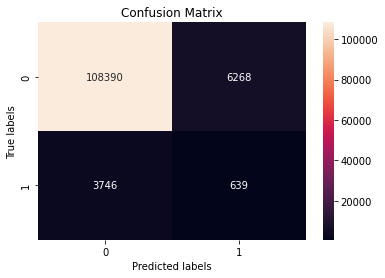

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


**4.3 OBSERVATIONS:**


*   The Data set is highly imbalance so TP is less
*   In this problem FN should be less as company should be informed on customers who are going to claim for insurance.

## **5.Training on whole data set for Final Submission :**

In [ ]:
sss = StratifiedKFold(n_splits = 20, shuffle = True, random_state=19)
for train_index, valid_index in sss.split(X_Train_Final,Y):
  x_tr, x_valid = X_Train_Final.iloc[train_index], X_Train_Final.iloc[valid_index]
  y_tr, y_valid = pd.DataFrame(Y).iloc[train_index], pd.DataFrame(Y).iloc[valid_index]
  lgb_train = lgb.Dataset(x_tr, label=y_tr)
  lgb_eval = lgb.Dataset(x_valid, label=y_valid)
  mdl = lgb.train(param,lgb_train,valid_sets=[lgb_eval,lgb_train],verbose_eval=25, feval=gini_lgb,early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds.
[25]	training's binary_logloss: 0.1523	training's gini: 0.279148	valid_0's binary_logloss: 0.152876	valid_0's gini: 0.253917
[50]	training's binary_logloss: 0.151461	training's gini: 0.296716	valid_0's binary_logloss: 0.152388	valid_0's gini: 0.26588
[75]	training's binary_logloss: 0.151054	training's gini: 0.306177	valid_0's binary_logloss: 0.152202	valid_0's gini: 0.271712
[100]	training's binary_logloss: 0.150768	training's gini: 0.313069	valid_0's binary_logloss: 0.152136	valid_0's gini: 0.273848
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.150768	training's gini: 0.313069	valid_0's binary_logloss: 0.152136	valid_0's gini: 0.273848
Training until validation scores don't improve for 50 rounds.
[25]	training's binary_logloss: 0.152282	training's gini: 0.279851	valid_0's binary_logloss: 0.152784	valid_0's gini: 0.249883
[50]	training's binary_logloss: 0.151461	training's gini: 0.297048	

In [ ]:
X_Test_final=test_data.drop(['id'],axis=1)
X_Test_final_with_imp_features=X_Test_final[Final_features]

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_data['id']
sub['target'] = mdl.predict(X_Test_final_with_imp_features)
sub.to_csv('final_submit.csv', float_format='%.6f', index=False)

In [ ]:
print(pd.read_csv('/content/final_submit.csv').shape)

(892816, 2)


## **6.Score obtained on Kaggle :**

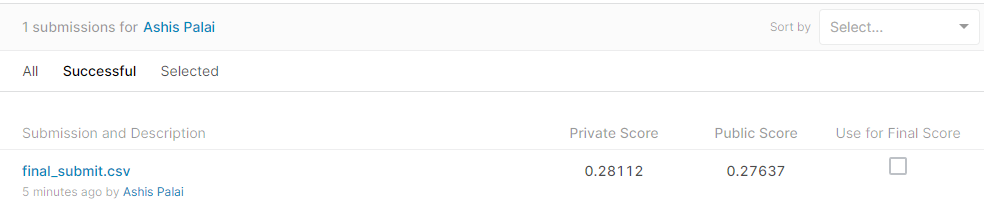